<a href="https://colab.research.google.com/github/vijaythamalla/CIFAR10/blob/master/CIFAR10_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os,datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization
from tensorflow.keras.layers import Dropout,Conv2D,MaxPool2D
from tensorflow.keras.layers import LeakyReLU,Input,Activation
from tensorflow.keras.optimizers import SGD,Adam,Nadam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
(X_train,y_train),(X_test,y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
X_train.shape

(50000, 32, 32, 3)

In [4]:
y_train.shape

(50000, 1)

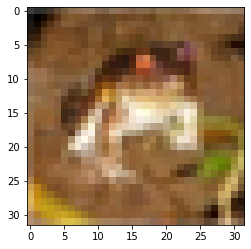

In [5]:
plt.imshow(X_train[0])

In [6]:
y_train[0]

array([6], dtype=uint8)

In [7]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [8]:
classes[int(y_train[0])]

'frog'

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [22]:
logs_base_dir = "./logs"
log_dir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
filepath= os.path.join(logs_base_dir,'model.{epoch:02d}-{val_loss:.2f}.h5')

os.makedirs(logs_base_dir, exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath),
    tf.keras.callbacks.TensorBoard(log_dir),
    #tf.keras.callbacks.ReduceLROnPlateau()
]

In [23]:
def inception(layer_in,f1,f3_in,f3_out,f5_in,f5_out,fp):
    # 1x1 conv layer
    conv1 = Conv2D(f1,1,1,padding='same')(layer_in)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Dropout(0.2)(conv1)
    # 3x3 conv layer
    conv3 = Conv2D(f3_in,1,1,padding='same')(layer_in)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(f3_out,3,1,padding='same')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Dropout(0.2)(conv3)
    # 5x5 conv layer
    conv5 = Conv2D(f5_in,1,1,padding='same')(layer_in)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(f5_out,5,1,padding='same')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Dropout(0.2)(conv5)
    # MaxPooling layer
    pool = MaxPool2D(3,1,padding='same')(layer_in)
    pool = Conv2D(fp,1,1,padding='same')(pool)
    pool = LeakyReLU(0.2)(pool)

    output = keras.layers.concatenate([conv1,conv3,conv5,pool])
    return output

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)

inputs = Input(shape=(X_train.shape[1:]))

conv_m1 = Conv2D(32,kernel_size=3,padding='same')(inputs)
pool_m1 = MaxPool2D(2)(conv_m1)

layer_1 = inception(pool_m1,32,32,64,32,32,32)
conv_m2 = Conv2D(64,kernel_size=3,padding='same')(layer_1)
bn_m1 = BatchNormalization()(conv_m2)
act_m1 = LeakyReLU(0.2)(bn_m1)
drop_m1 = Dropout(0.2)(act_m1)
pool_m2 = MaxPool2D(2)(act_m1)

layer_2 = inception(pool_m2,32,32,64,32,32,32)
conv_m3 = Conv2D(128,3,1,padding='same',activation='relu')(layer_2)
bn_m2 = BatchNormalization()(conv_m3)
act_m2 = LeakyReLU(0.2)(bn_m2)
drop_m2 = Dropout(0.5)(act_m2)

#pool_2 = MaxPool2D(2)(layer_2)
flat = Flatten()(drop_m2)
#hidden = Dense(128,activation='relu')(flat)
output = Dense(10,activation='sigmoid')(flat)

model = keras.Model(inputs=inputs,outputs=output)

model.summary()

optimizers = Adam()

model.compile(optimizer=optimizers,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train,batch_size=32,epochs=10,validation_split=0.2,callbacks=callbacks)

model.evaluate(X_test,y_test)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   1056        max_pooling2d[0][0]              
_______________________________________________________________________________________

[0.6483609676361084, 0.7847999930381775]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential([
        # Input Layer
        Conv2D(32,kernel_size=3,padding='same',input_shape=X_train.shape[1:]),
        keras.layers.LeakyReLU(),
        keras.layers.MaxPool2D(2),
        Conv2D(64,kernel_size=3,padding='same'),
        keras.layers.LeakyReLU(),
        Conv2D(64,kernel_size=3,padding='same'),
        keras.layers.LeakyReLU(),
        keras.layers.MaxPool2D(2),
        Conv2D(128,kernel_size=3,padding='same'),
        BatchNormalization(),
        keras.layers.LeakyReLU(),
        Conv2D(128,kernel_size=3,padding='same'),
        BatchNormalization(),
        keras.layers.LeakyReLU(),
        Dropout(0.3),
        Flatten(),
        # First Hidden Layer
        Dense(128),
        BatchNormalization(),
        keras.layers.LeakyReLU(),
        Dropout(0.5),
        # Output Layer
        Dense(10,activation='softmax')
])

model.summary()

optimizers = Nadam()

model.compile(optimizer=optimizers,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train,batch_size=32,epochs=100,validation_split=0.2,callbacks=callbacks)

model.evaluate(X_test,y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0

[0.6675499081611633, 0.7867000102996826]